First we must import numpy and SINDy

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysindy import SINDy
from pysindy.feature_library import *
from pysindy.differentiation import *
# from pysindy.optimizers import *
from scipy.integrate import odeint, solve_ivp

# Import reduced dataset
file = '../ReducedTorqueData.csv'
raw_data = np.loadtxt(file, delimiter=',', skiprows=1)

# file = 'FullDataset.csv'
# raw_data = np.loadtxt(file, delimiter=',', skiprows=500001, nrows=500000)

data = raw_data[0:raw_data.shape[0]:5]

pd.DataFrame(data[:5], columns = ['Time','i_a','i_b','i_c','u_a','u_b','u_c','e'])

,Time,i_a,i_b,i_c,u_a,u_b,u_c,e
0,0.000000,1.765625,3.453125,0.937500,-0.322917,-0.677083,1.000000,-2.403804
1,0.000005,1.609375,3.578125,0.671875,-0.083333,-0.843750,0.927083,-2.403609
2,0.000010,1.250000,4.093750,0.218750,-0.552083,-0.906250,1.458333,-2.403414
3,0.000015,1.015625,4.031250,0.750000,-0.645833,-0.979167,1.625000,-2.403220
4,0.000020,0.937500,4.218750,0.781250,-0.552083,-0.927083,1.479167,-2.403025


In [24]:
# Given Parameters
n_me = 16.67    # Hz
U_DC = 294      # Volts DC
Rs = 18e-3      # Ohms
Ld = 370e-6     # Henry
Lq = 1200e-6    # Henry
psi_p = 66e-3   # Vs
i_dqmax = 240   # Amps
p = 3           # pole pair number

In [25]:
# Split data and calculate X_dq
t = data[:, 0]
i_abc = data[:, 1:4]
u_abc = data[:, 4:7]
e = data[:, 7]

i_dq = np.zeros((len(data), 2))
u_dq = np.zeros((len(data), 2))
for i in range(len(data)):
    trig = np.array([[np.cos(e[i]), -np.cos(e[i] + np.pi/3), -np.cos(e[i] - np.pi/3)],
                    [-np.sin(e[i]), np.sin(e[i] + np.pi/3), np.sin(e[i] - np.pi/3)]])
    i_dq[i] = np.matmul(trig, i_abc[i])
    u_dq[i] = np.matmul(trig, u_abc[i])

psi_d = Ld*i_dq[:, 0] + psi_p
psi_q = Lq*i_dq[:, 1]
T = 1.5*p*(psi_d*i_dq[:, 1] - psi_q*i_dq[:, 0])

X = np.column_stack((T, 
                     i_dq, 
                     u_dq, 
                     np.sin(e), 
                     np.cos(e)
                     ))

kernel_size = 30
kernel = np.ones(kernel_size) / kernel_size
# T_convolved = np.convolve(T, kernel, mode='same')
X_convolved = np.zeros(X.shape)
for i in range(X.shape[1]):
    X_convolved[:,i] = np.convolve(X[:,i], kernel, mode='same')
    
# pd.DataFrame(X_convolved, columns = ['T','i_d','i_q','u_d','u_q','sin(e)','cos(e)'])

In [26]:
# Instantiate model
model = SINDy(
              feature_library=PolynomialLibrary(degree=1),
              # feature_library=FourierLibrary(n_frequencies=1),
              # feature_library=WeakPDELibrary(),
              differentiation_method=SmoothedFiniteDifference(),
              feature_names=['T','i_d','i_q','u_d','u_q','sin(e)','cos(e)']
            )

model.fit(X_convolved, t=t)
model.print()
model.coefficients()
model.score(X_convolved, t=t[1]-t[0])

(T)' = -21.553 1 + -846.538 T + 13.335 i_d + 254.866 i_q + -21.983 u_d + 13.365 u_q + -28.012 sin(e) + -18.933 cos(e)
(i_d)' = -381.958 1 + -20880.001 T + 564.998 i_d + 6088.732 i_q + 1221.599 u_d + -114.856 u_q + 1462.133 sin(e) + 484.416 cos(e)
(i_q)' = -55.354 1 + -1737.212 T + 14.751 i_d + 532.555 i_q + -137.217 u_d + 50.644 u_q + -171.196 sin(e) + -88.797 cos(e)
(u_d)' = 1570.944 1 + 33987.808 T + -4048.897 i_d + -9405.256 i_q + -216.330 u_d + -54.612 u_q + -1181.986 sin(e) + 4858.060 cos(e)
(u_q)' = -3948.424 1 + -5270.161 T + -264.819 i_d + 619.290 i_q + 271.699 u_d + -33.065 u_q + -1154.615 sin(e) + 137.506 cos(e)
(sin(e))' = -2.950 1 + -84.076 T + 1.363 i_d + 24.221 i_q + -0.870 u_d + -2.547 sin(e) + 36.414 cos(e)
(cos(e))' = -1.421 1 + 75.791 T + -2.516 i_d + -22.847 i_q + -1.156 u_d + -40.144 sin(e) + 1.075 cos(e)


0.03563823994183297

In [27]:
tspan = [t[0], t[-1]]
X0 = X[0]
# x_SINDy = solve_ivp(model, tspan, X0, t_eval=t)
sim = model.simulate(X0, t=t)               # sim should match X if there was no error
print(sim)

[[-0.57277434 -1.14748849 -1.90109925 ...  0.7488959  -0.67265325
  -0.73995784]
 [-0.57288989 -1.1496796  -1.90137293 ...  0.74495283 -0.67279724
  -0.73982707]
 [-0.57300652 -1.15182558 -1.90165259 ...  0.74102664 -0.67294124
  -0.7396963 ]
 ...
 [-0.96828618 -0.99057553 -3.22743928 ...  5.30939465 -0.67985832
  -0.74610555]
 [-0.968012   -0.99904168 -3.22607841 ...  5.30974499 -0.67999311
  -0.74596902]
 [-0.9677377  -1.00752492 -3.22471619 ...  5.31010321 -0.68012788
  -0.74583241]]


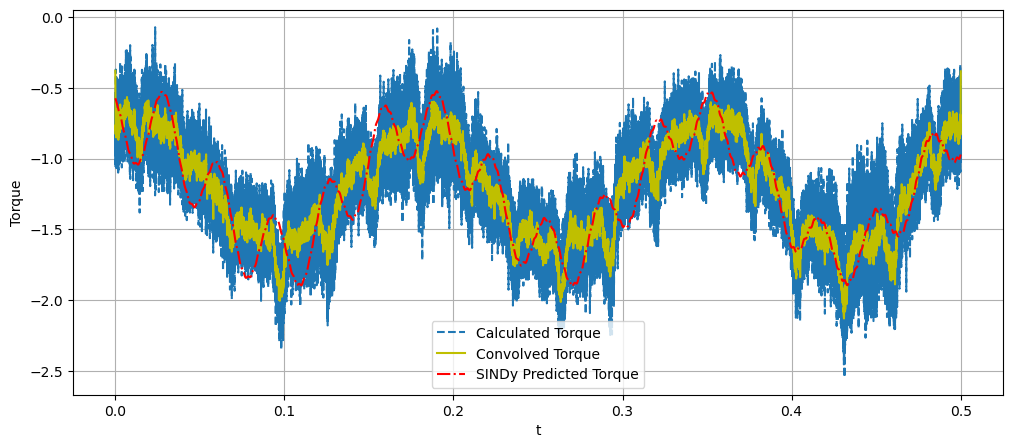

In [29]:
T_SINDy = sim[:,0]

plt.figure(figsize=(12,5))
plt.plot(
        t, T, '--', 
        t, X_convolved[:,0], 'y-', 
        t, T_SINDy, 'r-.')
plt.xlabel('t')
plt.ylabel('Torque')
plt.legend([
            'Calculated Torque',
            'Convolved Torque',
            'SINDy Predicted Torque'])
plt.grid()
plt.show()

In [ ]:
# # Define weak form ODE library
# # defaults to derivative_order = 0 if not specified,
# # and if spatial_grid is not specified, defaults to None,
# # which allows weak form ODEs.
# library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
# library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
# ode_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     spatiotemporal_grid=t_train,
#     is_uniform=True,
#     K=100,
# )